### Calculate the Word Mover's Distance between two sentences

In [1]:
import gensim.downloader as api
import glob
import sys
import os
import pandas as pd

from tqdm import tqdm

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

### Read demographic groups' sentences

In [2]:
buckeye_datapath = AbsolutePathBuilder.get_path(
    "04_buckeye_scored",
    filepaths="../../../../config/filepaths.yaml"
)

df_white = pd.concat(
    [pd.read_csv(file) for file in glob.glob(os.path.join(buckeye_datapath, "*"))],
    ignore_index=True
)

coraal_datapath = AbsolutePathBuilder.get_path(
    "04_coraal_scored",
    filepaths="../../../../config/filepaths.yaml"
)

df_black = pd.concat(
    [pd.read_csv(file) for file in glob.glob(os.path.join(coraal_datapath, "*"))],
    ignore_index=True
)

---
### Load embedding model

In [5]:
# https://github.com/RaRe-Technologies/gensim-data

embedding_model = api.load("glove-wiki-gigaword-50")

In [6]:
import numpy as np

output_path = AbsolutePathBuilder.get_path(
    f"07_coraal_vs_buckeye_wmd",
    filepaths="../../../../config/filepaths.yaml"
)

file_idx = 0
data = []
distances = []
for idx, row_white in tqdm(df_white.iterrows(), total=df_white.shape[0]):
    closest_row_black = None
    closest_dist = np.inf
    for _, row_black in df_black.iterrows():
        cur_distance = embedding_model.wmdistance(row_white.text, row_black.text)

        if(cur_distance < closest_dist):
            closest_dist = cur_distance
            closest_row_black = row_black

    closest_row_black.index = [f"{name}_black" for name in closest_row_black.index]
    concatenated_row = pd.concat([closest_row_black, row_white])
    
    data.append(concatenated_row)
    distances.append(closest_dist)
    
    if (idx % 250) or (idx == df_white.index[-1]):
        df_wmd = pd.DataFrame(data)
        df_wmd = df_wmd.reset_index(drop=True)

        df_wmd["wmd"] = distances

        data = []
        distances = []
        df_wmd.to_csv(os.path.join(output_path, f"buckeye_vs_coraal_wmd_p{file_idx}.csv"), index=False)
        file_idx += 1

100%|██████████████████████████████████████████████████████████| 19304/19304 [00:39<00:00, 490.90it/s]


/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-p

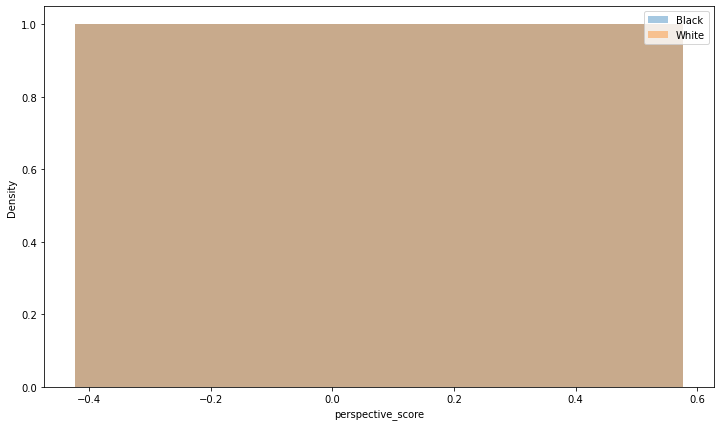

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,7))

sns.distplot(df_wmd.perspective_score_black, label="Black")
sns.distplot(df_wmd.perspective_score, label="White")

plt.legend()
plt.show()

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


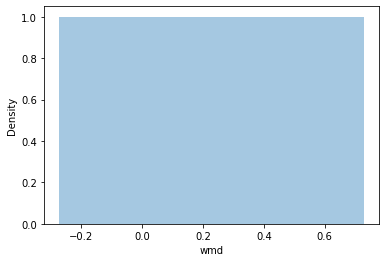

In [8]:
sns.distplot(df_wmd.wmd)
plt.title("")
plt.show()